### ISC CamCan Suspense

The goal of this notebook is to perform a supplementary analysis on resting state data (not aligned by the movie)

### setting up modules

In [1]:
import os, sys, scipy, nilearn, warnings
warnings.filterwarnings("ignore")

import numpy as np
import nibabel as nib
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

#import tables as tb         # PyTables library does on disk (i.e. bigger than memory matrices storage)
import matplotlib.pyplot as plt
%matplotlib inline

from camcan_utils import *

### set up files

In [2]:
suspense_file         = '../../data/avg_suspense.npy'
dict_file             = '../../data/timeseries_dictionary.npy'
dyn_isc_file          = '../../data/dyn_isc_dict.npy'
shen_dictionary_file  = '../../data/shen_dictionary.npy'
shen_atlas_filename   = '../../data/shen_2mm_268_parcellation.nii'
sample_file           = '../../data/func.nii'

### load data 

In [3]:
# read in the time series data to get access to the raw BOLD activation values 
read_dictionary = np.load(dict_file).item()

subjs = list(read_dictionary.keys())
n_subjs = len(subjs)

n_tr_rest, n_regions = read_dictionary[subjs[0]]['funcdata_rest'].shape
#ts_data = np.zeros((n_tr, n_regions, n_subjs))
age_data = np.zeros((n_subjs))
gender_data = np.zeros((n_subjs))

rest_list = [] 
#re-create ts_data
for curr_sub in range(n_subjs):
    curr_sub_name                = subjs[curr_sub]
    age_data[curr_sub] = read_dictionary[curr_sub_name]['age']
    gender_data[curr_sub] = read_dictionary[curr_sub_name]['gender']
    if np.asarray(read_dictionary[curr_sub_name]['funcdata_rest']).shape == (n_tr_rest, n_regions):
        rest_list.append(read_dictionary[curr_sub_name]['funcdata_rest'])
        #things are a bit cumbersome for the resting state data because - due to artifact control etc, different subjects pass the threshold
        
ts_data_rest = np.asarray(rest_list)
ts_data_rest = np.swapaxes(ts_data_rest, 0,2)
ts_data_rest = np.swapaxes(ts_data_rest, 0,1)
del rest_list, read_dictionary

### ISC on resting state data

In [5]:
''' precomputed because the phase randomization takes time
sk = 50
D_rest = ts_data_rest[sk:, :, :] 
# there is apparently a strong transient in the resting state data, 
# possibly because subjects were instructed to close their eyes after the start of the scan or similar factor

#print('Calculating ISC on ', D_rest.shape[1], ' voxels/regions and ', D_rest.shape[2], ' subjects')

ISC_rest, p_rest, distribution_rest = camcan_phaseshift_isc(D_rest, 
                                           #pairwise=True,
                                           summary_statistic=np.mean,
                                           n_shifts = 250, #can reduce to speed up
                                           return_distribution=True)
ISC_rest[np.isnan(ISC_rest)] = 0

alpha = .05
# Get q-values (i.e., FDR-controlled p-values) 
q = multipletests(p_rest[0, :], method='fdr_by')[1]
corrected = q[np.newaxis, :] < alpha
ISC_rest[corrected == False] = 0

isc_rest_result_dict = {}
isc_rest_result_dict['ISC']          = ISC_rest
isc_rest_result_dict['p']            = p_rest
isc_rest_result_dict['distribution'] = distribution_rest

# can plot FDR plot
#plt.plot(np.sort(np.squeeze(q)));
#plt.plot(np.sort(np.squeeze(p_rest)));

#np.save('../data/isc_rest_result_dict.npy', isc_rest_result_dict) '''

# if precomputed, just load results
isc_rest_result_dict = np.load('../../data/isc_rest_result_dict.npy').item()
ISC_rest             = isc_rest_result_dict['ISC']          
p_rest               = isc_rest_result_dict['p']            
distribution_rest    = isc_rest_result_dict['distribution'] 

### plot resting-ISC (which is nonexistent) (Figure 2D)

/Users/Ralf/anaconda3/lib/python3.6/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


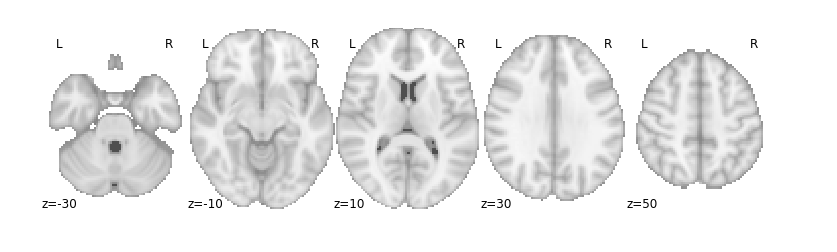

In [6]:
# need to re-fit the masker first to be able to plot results
shen_masker = NiftiLabelsMasker(labels_img=shen_atlas_filename);
shen_masker.fit_transform(sample_file);

#isc_rest_vector = np.reshape(ISC_rest, (1,n_regions));
res_img_rest = shen_masker.inverse_transform(ISC_rest);

f = plt.figure(figsize=(14,4));
ax1 = f.add_subplot(111)
nilearn.plotting.plot_stat_map(nilearn.image.index_img(res_img_rest,0), 
                               resampling_interpolation = 'linear',
                               threshold = 0.0, 
                               vmax = 0.7, 
                               draw_cross = True,
                               display_mode = 'z',
                               cut_coords = [-30, -10, 10,  30,  50],
                               annotate = True,
                               #title = "ISC on resting-state data (corrected)",
                               axes = ax1);

### create time series plot from resting state data (Figure 2D)

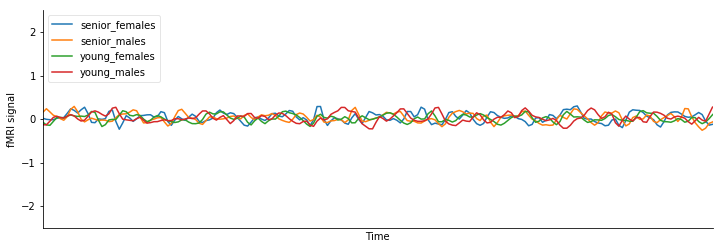

In [7]:
# create four groups
title_list = ['senior_females','senior_males','young_females','young_males']
senior_females = np.intersect1d(np.where((gender_data == 2)), np.where(age_data > np.mean(age_data)), assume_unique=False)
senior_males   =  np.intersect1d(np.where((gender_data == 1)), np.where(age_data > np.mean(age_data)), assume_unique=False)
young_females  =  np.intersect1d(np.where((gender_data == 2)), np.where(age_data < np.mean(age_data)), assume_unique=False)
young_males    =  np.intersect1d(np.where((gender_data == 1)), np.where(age_data < np.mean(age_data)), assume_unique=False)
senior_females =  senior_females[senior_females < 405] #rest has less
senior_males   =  senior_males[ senior_males    < 405]
young_females  =  young_females[young_females   < 405]
young_males    =  young_males[young_males       < 405]
cond_list = [senior_females, senior_males, young_females, young_males]

# plot the region
curr_region = 37 #same as for movie-analysis
plt.figure(figsize = (12,4))
for curr in range(4):
    curr_subs = cond_list[curr]
    plt.plot( np.mean(ts_data_rest[50:,curr_region,curr_subs].T, axis = 0) , label = title_list[curr]);
plt.legend(loc = 2, fancybox=True, framealpha=0.5);
plt.xlabel('Time');
plt.ylabel('fMRI signal');
plt.xlim(0, 193);
plt.ylim(-2.5, 2.5)
plt.xticks([]);
sns.despine()